In [ ]:
%cd ..

In [1]:
# type: ignore

from __future__ import annotations

import typing
from typing import Literal, cast, TypeVar
from pathlib import Path
from datetime import timedelta
from dataclasses import dataclass
from itertools import groupby, pairwise
from collections.abc import Iterable

from datasets import load_dataset, Audio, load_from_disk # type: ignore
import gigaam
from gigaam.model import GigaAMASR
import soundfile as sf
from tqdm.auto import tqdm
import srt
import torch
import numpy as np
import numpy.typing as npt
from torchaudio.transforms import Resample
import matplotlib.pyplot as plt

from asr_eval.align.data import Token, MultiVariant, Anything
from asr_eval.models.gigaam import encode, decode, transcribe_with_gigaam_ctc, GigaAMEncodeError, FREQ
from asr_eval.streaming.timings import get_word_timings_simple, fill_word_timings_inplace
from asr_eval.utils import utterances_to_srt, groupby_into_spans
from asr_eval.align.parsing import parse_multivariant_string, colorize_parsed_string
from asr_eval.ctc.forced_alignment import forced_alignment
from asr_eval.plots import draw_timed_transcription

In [ ]:
model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

In [ ]:
# # type: ignore

# datasets = {
#     'podlodka': (
#         load_dataset('bond005/podlodka_speech')['test']
#         .cast_column("audio", Audio(sampling_rate=16_000))
#         .take(20)
#     ),
#     'golos_farfield': (
#         load_dataset('bond005/sberdevices_golos_100h_farfield')['test']
#         .cast_column("audio", Audio(sampling_rate=16_000))
#         .take(20)
#     ),
# }

# for dataset_name, dataset in datasets.items():
#     dir = Path(f'srt/{dataset_name}')
#     dir.mkdir(exist_ok=True, parents=True)
#     for sample_idx, sample in tqdm(enumerate(dataset)):
#         waveform = sample['audio']['array']
#         text = sample['transcription']
#         text = text.lower().replace('ё', 'е').replace('-', ' ')
#         for char in ('.', ',', '!', '?', ';', ':', '"', '(', ')'):
#             text = text.replace(char, '')
#         try:
#             encode(model, text)
#         except ValueError:
#             print(f'Cannot encode: {text}')
#             continue
#         timings = get_word_timings(model, waveform, text)
#         (dir / f'{sample_idx}.srt').write_text(utterances_to_srt(timings))
#         sf.write(dir / f'{sample_idx}.wav', waveform, samplerate=16_000)
#         break

In [3]:
dataset = load_from_disk('tmp/multivariate/multivariant_v1_200')

sample = dataset[64] # type: ignore

waveform = Resample(22050, 16000, dtype=torch.float64)(
    torch.tensor(np.array(sample['audio']['array'])) # type: ignore
).numpy()

blocks = [
    x
    for x in srt.parse(sample['trans']) # type: ignore
    if x.end < timedelta(seconds=15)
]

finish_time = blocks[-1].end.total_seconds()
waveform = waveform[:int(16000*finish_time)]

text = ' '.join(x.content for x in blocks).replace('{?}', '<*>').replace('}.', '} .')

tokens = parse_multivariant_string(text)
print(colorize_parsed_string(text, tokens)[0])

Ух ты, и снова я, Александр Криволат, печенеги. Ребята, сегодня {24 | двадцать четвертое | двадцать четвёртое} мая {2021 | две тысячи двадцать первого} года.


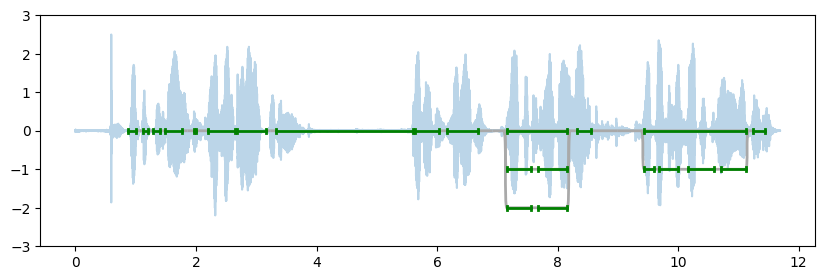

In [5]:
fill_word_timings_inplace(model, waveform, tokens)

plt.figure(figsize=(10, 3)) # type: ignore
plt.plot( # type: ignore
    np.arange(len(waveform)) / 16_000,
    2.5 * waveform / waveform.max(),
    alpha=0.3,
    zorder=-1,
)
draw_timed_transcription(tokens)

plt.ylim(-3, 3) # type: ignore
plt.show() # type: ignore